In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<center>
    <font size=6> **Recipe of Deep Learning** </font>
</center>

-----

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/nn_training/1.png)

<font size=2>
其中 `Early Stopping，Regularization，Dropout` 用于解决过拟合 (high test error)，`New activation function，Adaptive Learning Rate` 用于解决欠拟合 (high training error)。
</font>
<br><br>

<center>
    <font size=6> **Optimizers** </font>
</center>

-----

### SGD的缺点

<br>

<font size=2>
    在下图中, SGD 呈“之”字形移动。这是一个相当低效的路径。也就是说,
SGD 的缺点是,如果函数的形状非均向(anisotropic),比如呈延伸状,搜索
的路径就会非常低效。因此,我们需要比单纯朝梯度方向前进的 SGD 更聪
明的方法。SGD 低效的根本原因是,梯度的方向并没有指向最小值的方向。
</font>
<br>
![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/ch06_1.png)

### Momentum
<br>
<font size=2>
$$\begin{align*}
\mathbf{v} &= \alpha \bf{v} - \eta \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \\[1ex]
\boldsymbol{\theta} &= \boldsymbol{\theta} + \mathbf{v} \\[3ex]
\mathbf{v} &= \alpha \bf{v} - \eta \nabla_{\boldsymbol{\theta}} \left(\frac{1}{m} \sum\limits_{i=1}^m L (f(x_i; \boldsymbol{\theta}), \;y_i)\right) \\
\boldsymbol{\theta} &= \boldsymbol{\theta} + \mathbf{v}
\end{align*}
$$  

</font>

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### AdaGrad
<br>

$$
\begin{align*}
\mathbf{h} &= \mathbf{h} + \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \odot \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \\[1ex]
\boldsymbol{\theta} &= \boldsymbol{\theta} - \frac{\eta}{\sqrt{\mathbf{h}} + \delta} \odot \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta})
\end{align*}
$$

In [ ]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.v is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### RMSprop
<br>
<font size=2>
    AdaGrad 由于 $h$ 的累积，到最后的更新会变得非常缓慢。RMSProp对此的解决办法是逐渐遗忘过去的梯度，以指数衰减平均 (exponentially decaying average) 的形式。Hinton 建议 $\rho$ 一般取0.9，$\eta$ 一般取0.001
</font>
<br><br>

$$
\begin{align*}
\mathbf{h} &= \rho\,\mathbf{h} + (1 - \rho)\nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \odot \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \\[1ex]
\boldsymbol{\theta} &= \boldsymbol{\theta} - \frac{\eta}{\sqrt{\mathbf{h}} + \delta} \odot \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta})
\end{align*}
$$

In [4]:
class RMSprop:
    def __init__(self, lr=0.001, decay_rate=0.9):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam
<br>
$$
\begin{align*}
t &= t + 1 \\
\mathbf{v} &= \rho_1 \bf{v} + (1 - \rho_1) \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \\[1ex]
\mathbf{h} &= \rho_2 \mathbf{h} + (1 - \rho_2)\nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \odot \nabla_{\boldsymbol{\theta}} L (\boldsymbol{\theta}) \\
\hat{\mathbf{v}} &= \frac{\boldsymbol{v}}{1 - \rho_1^t} \\
\hat{\mathbf{h}} &= \frac{\mathbf{h}}{1-  \rho_2^t} \\
\boldsymbol{\theta} &= \boldsymbol{\theta} - \eta \frac{\hat{\mathbf{v}}}{\sqrt{\hat{\mathbf{r}}}+ \delta}
\end{align*}
$$

In [5]:
class Adam:
    def __init__(self, rho1=0.9, rho2=0.999, lr=0.001):
        self.lr = lr
        self.rho1 = rho1
        self.rho2 = rho2
        self.v = None
        self.h = None
        self.iter = 0
        
    def update(self, params, grads):
        if self.v is None:
            self.v, self.h = {}, {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.iter += 1
            self.v[key] = self.rho1 * self.v[key] + (1 - self.rho1) * grads[key]
            self.h[key] = self.rho2 * self.v[key] + (1 - self.rho2) * (grads[key] ** 2)
            unbias_v = self.v[key] / (1 - self.rho1 ** self.iter)
            unbias_h = self.h[key] / (1 - self.rho2 ** self.iter)
            params[key] -= self.lr * unbias_v / (np.sqrt(unbias_h) + 1e-8)

<br><br><br>
<center>
    <font size=6> 
        **Weight Initialization**
    </font>
</center>

---------

<font size=2>
不能将权重初始值都设为0，因为这样在反向传播时，拥有相同输入和激活函数的不同神经元的权重会被更新为相同的值，这使得神经网络拥有许多不同的权重的意义丧失了。为了 "打破均一化 (break symmetry)"，需要将权重随机初始化。一般从高斯分布或均匀分布中随机抽取值，分布的标准差越大，越有利于权重的多样性。然而过大的权重容易导致梯度爆炸。 另一方面，对于 Sigmoid 来说，过大的权重导致激活值饱和，进而引起梯度消失 (如下图)。
相对而言过小的标准差则会造成权重相似。
<br><br>
一般希望激活值的分布有适当的广度，因为通过在各层间传递多样性的数据，神经网络可以进行高效的学习。
<br><br><br>
Xavier 初始<br>值： $$\sigma = \frac{1}{\sqrt{n_{\small{input}}}}$$  适用于 Sigmoid 和 Tanh 函数
<br><br><br>
He 初始值：  $$\sigma = \frac{2}{\sqrt{n_{\small{input}}}}$$   适用于 Relu 函数
<br><br><br>
下图显示不同的初始值和激活函数下，隐藏层激活值的分布: 
</font>

In [7]:
from collections import defaultdict

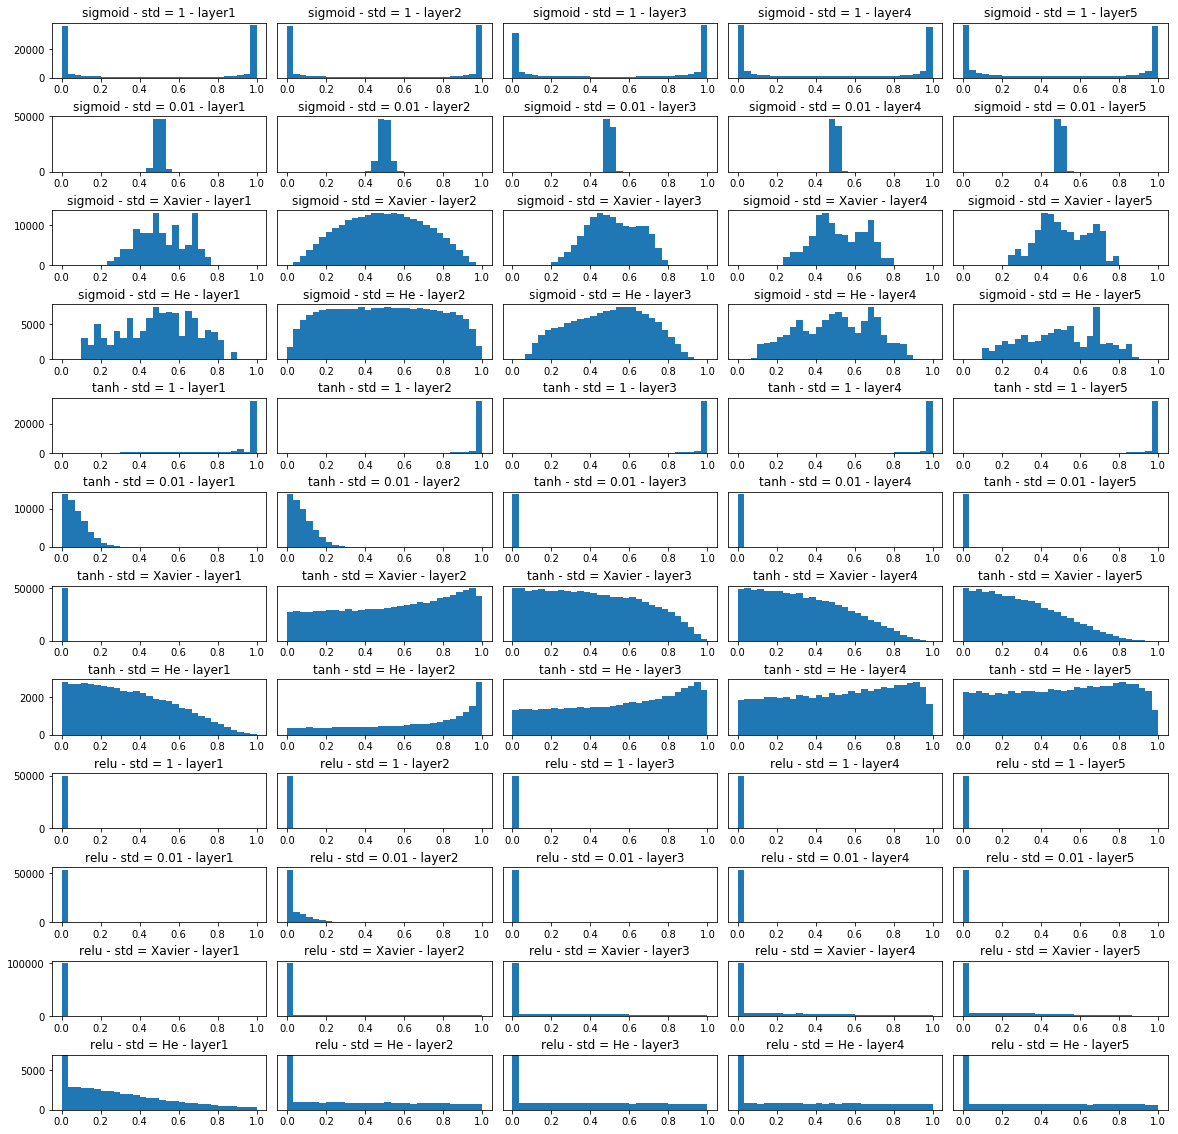

In [39]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def tanh(z):
    return np.tanh(z)

input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = defaultdict(list)
a = input_data
functions = [sigmoid, tanh, relu]
weights = [np.random.randn(node_num, node_num) * 1,
           np.random.randn(node_num, node_num) * 0.01,
           np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num),
           np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)]
f_names = ["sigmoid", "tanh", "relu"]
names = ["std = 1", "std = 0.01", "std = Xavier", "std = He"]

i = 1
plt.figure(figsize=(20, 20))
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.7)
for f, f_name in zip(functions, f_names):
    for w, name in zip(weights, names):
        for l in range(hidden_layer_size):
            z = np.dot(a, w)
            a = f(z)
            plt.subplot(12, hidden_layer_size, i)
            plt.title("{} - {} - layer{}".format(f_name, name, l+1))
            if (i-1) % 5 != 0:
                plt.yticks([], [])
            plt.hist(a.flatten(), 30, range=(0,1))
            if name == "std = He" and f_name == "relu":
                plt.ylim(0, 7000)
            if (i-1) % 5 == 0:
                a = input_data
            i += 1

<br><br><br>
<center>
    <font size=6> 
        **Batch Normalization**
    </font>
</center>

---------


Batch Normalization 本质上是一种 adaptive reparametrization 的方法，其优点为：
1. 可以使学习快速进行（本来有covariance-shift，学习率调较小，有了 BN 后可以增大学习率）
2. 不那么需要依赖初始值了 (参数同乘 k 倍，结果不变，见下图)
3. 抑制过拟合（降低 Dropout 等的必要性）
4. 缓解梯度爆炸/消失问题 (因为值集中在 0 附近，Sigmoid、Tanh不容易饱和)


<br>
![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/nn_training/5.png)
<br>

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/ch06_2.png)

$$
\begin{align}
\mu_B &= \frac{1}{m} \sum\limits_{i=1}^m x_i \\[1ex]
\sigma_B &= \sqrt{\frac{1}{m} \sum\limits_{i=1}^m (x_i - \mu_B)^2 + \delta} \\[1ex]
\hat{x}_i &= \frac{x_i - \mu_B}{\sigma_B} \\[1ex]
y_i &= \gamma \hat{x}_i + \beta
\end{align}
$$
<br><br>
其中一开始 $\gamma = 1, \beta = 0$，之后通过学习调整到合适的值。

<font size=3>
    <center>
[Batch Normalization 反向传播](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
    </center>
</font>

In [40]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv层的情况下为4维，全连接层的情况下为2维  

        # 测试时使用的平均值和方差
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward时使用的中间数据
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

<br><br><br>
<center>
    <font size=6> 
        **Dropout**
    </font>
</center>

---------

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/ch06_3.png)

<font size=2>
Dropout 是一种在学习的过程中随机删除神经元的方法。训练时，随机选出隐藏层的神经元,然后将其删除。被删除的神经元不再进行信号的传递。训练时，每传递一次数据，就会随机选择要删除的神经元。然后测试时，虽然会传递所有的神经元信号，**但是对于各个神经元的输出，要乘上训练时的删除比例后再输出**。
</font>

In [43]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_rate)
        
    def backward(self, dout):
        return dout * self.mask

### 指定超参数搜索范围

In [50]:
np.logspace(-3,3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [52]:
weight_decay = 10 ** np.random.uniform(-8, -4)
weight_decay

5.872725780455652e-07

## Maxout

<font size=2>
    Maxout 是一种可以自动学习的 activation function，ReLU 可视为 Maxout 的特例。Maxout 单元的输入是上一层神经元的全部原始输入，因而是一个向量，其将上一层的神经元分成不同的组，每个组取最大值：
    <br><br>
    $$g(\textbf{z})_i = \sum\limits_{j \in \mathbb{G}^{(i)}} z_j$$
    <br>
    
    Maxout 相当于学习了一个分段线性函数 (piecewise linear function)，Maxout可以模拟 ReLU 的效果，也可以模拟leaky ReLU，Parametric ReLU 或其他任何凸函数。 因为分成 k 段，所以 Maxout 有k个参数，因而比 ReLU 需要更多的正则化。
</font>

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/nn_training/2.png)
<br>

-----
<br><br><br>
<font size=6>
    <center> **L2 & L1 regularization** </center>
</font>
<br>

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/nn_training/3.png)

![](https://raw.githubusercontent.com/massquantity/DL_from_scratch_NOTE/master/pic/nn_training/4.png)

<font size=2>
上面的最后 L1 正则化的式子：
<br><br>
$$
\begin{align*}
& \quad\;\; w^t - \eta \frac{\partial \mathcal{L}}{\partial w} - \eta \, \lambda\, \text{sign}(w) \\[1ex]
& = 
\begin{cases}
w^t - \eta \frac{\partial \mathcal{L}}{\partial w} - \eta \, \lambda , & \text{if}  \;w > 0 \\[1ex]
w^t - \eta \frac{\partial \mathcal{L}}{\partial w} + \eta \, \lambda , & \text{if}  \; w < 0
\end{cases}
\end{align*}
$$
   <BR><BR>
       
对比 L2 和 L1 正则化，L2 每次乘以 $(1-\eta \, \lambda)$ 以使 $w$ 减小，L1 每次以固定的值 $\pm \eta \lambda$ 来使 $w$ 向零靠近。 如果 $w$ 很大，使用 L2 会下降很快，而 L1 每次是固定的值，所以下降很慢。
<br>
L2 因为每次乘以 $(1-\eta \, \lambda)$ 所以会保留很多小的 $w$ ，因而比较平均。而 L1 则不会保留小的 $w$，结果是得到一些大的 $w$ 和其他大部分 $w$ 为零。
</font>

<br><br><br>
<center>
    <font size=6> **Tuning Learning Rate** </font>
</center>

-----

**learning rate** 是训练神经网络最重要的参数之一，设得太大跨过 global minimum，太小则容易卡在 local minimum。